## Chapter 9: Principles of Feature Engineering and Selection

#  9.3  Feature Scaling via Standard Normalization

In this Section and the following Section we two fundamental methods of *input normalization* - also called *feature scaling*.  While this sort of feature engineering step provides several benefits to the learning process that we will see throughout this Chapter, here we focus on how it *substantially improves learning speed when using first order optimization algorithms*.  As such this 'optimization trick' proves quite useful in our current context of linear machine learning, and will prove especially valuable when we deal with nonlinear learning in the future - like e.g., *deep networks* - where training via first order methods is all but essential.

In this Section we first explore the benefit of our first *feature scaling* technique: *standard normalization*.   We do this by exploring a number of simple supervised learning examples.  

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
classif_plotter = superlearn.lin_classification_demos
feature_scaling_tools = superlearn.feature_scaling_tools
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter_old.Visualizer()
cost_lib = superlearn.cost_functions
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# Other functionality 
import copy

# This is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

##   Standard normalization of regression datam

Below we load in and show a dataset we wish to perform linear regression on.  A quick glance at the data and we know that - if tuned properly - a linear regression will fit to this dataset exceedingly well, as the data appears to be roughly distributed on a line.

<IPython.core.display.Javascript object>


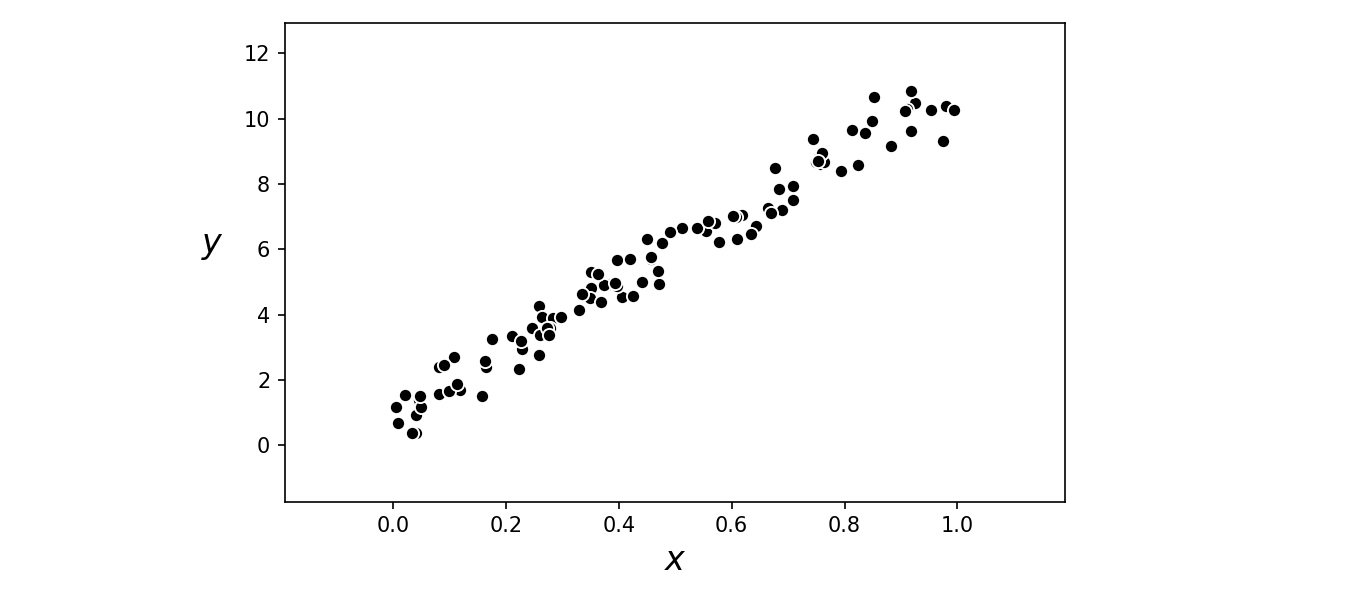

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# load data
data = np.loadtxt( datapath + 'unnorm_linregress_data.csv',delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

Since this is a low dimensional example with only two parameters to learn (the bias and slope of a best fit line) let us take a look at its associated Least Squares cost function.  Below we plot its contours in the usual fashion - with darker blue regions corresponding to larger points on the cost surface, and conversely lighter regions indicating lower points on the cost function.

in minimizing the Least Squares cost function using a simple linear regression dataset - which we load in / show below.  A quick glance at this dataset and we can tell that linear regression will provide  

<IPython.core.display.Javascript object>


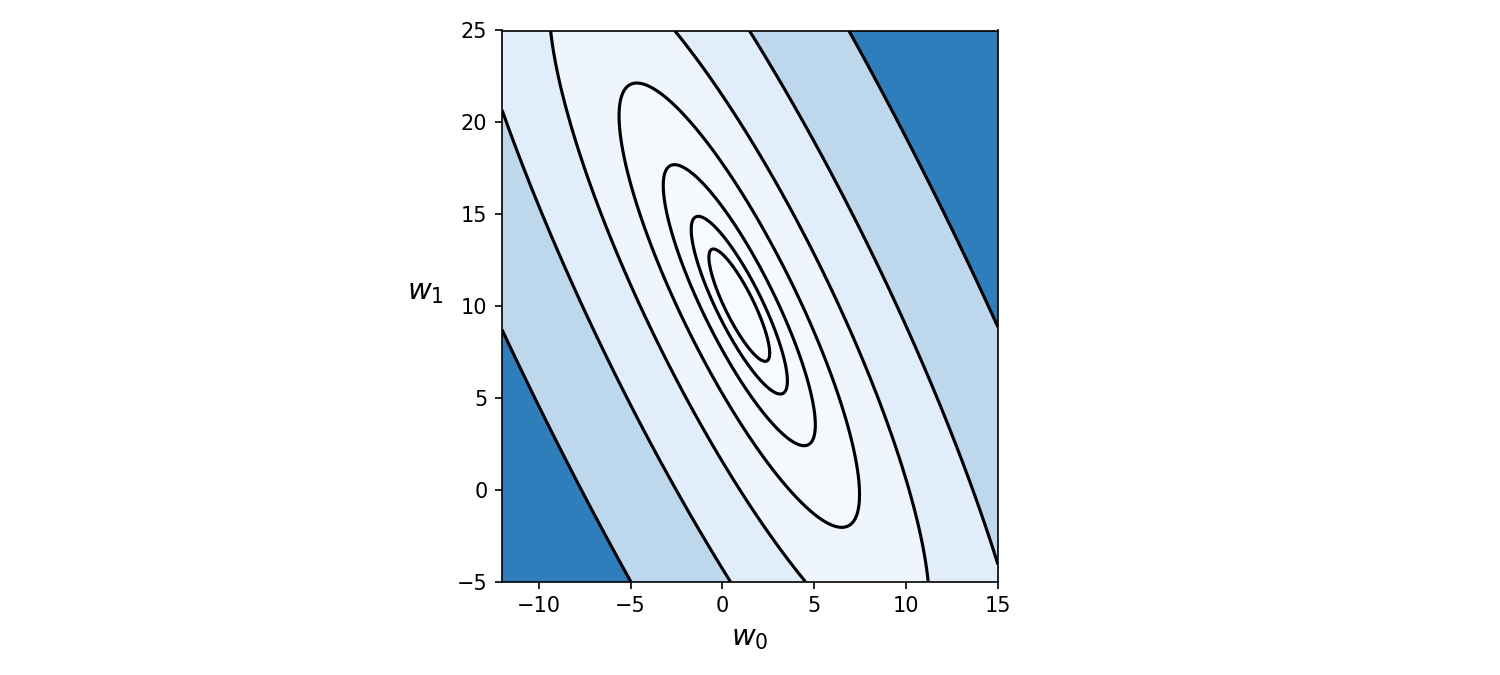

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares = cost_lib.choose_cost(x,y,'least_squares')

# show the contours of an input function over a desired viewing range
static_plotter.two_input_contour_plot(least_squares,[],xmin = -12,xmax = 15,ymin = -5,ymax = 25,num_contours = 7,show_original = False)

Notice how **elliptical** the contours of this cost function are - these create a long narrow valley along the long axis of the ellipses.  

While we can minimize this cost function using a variety of techniques, in this Section we will focus on employing gradient descent.  While we can certainly minimize this Least Squares cost using gradient descent, as discussed in [Section 3.6](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_6_Descent.html) this algorithm progresses quite slowly when applied to minimize a cost functions like the one shown above (with its long narrow valley).  So unless we luck out and initialize directly along the *short axes* of such an elliptical contour-having cost function, gradient descent will need to take a large number of steps to reach an approximate global minimum.  

We illustrate this fact by showing a run of $100$ gradient descent steps initialized at the point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$.  Here we use a fixed steplength parameter $\alpha = 10^{-1}$.  Here $10^{-1}$ was the largest value of $\alpha$ of the form $10^{-\gamma}$ we found that produced convergence from this initialization (larger values of $\alpha$ caused gradient descent to diverge).  

<IPython.core.display.Javascript object>


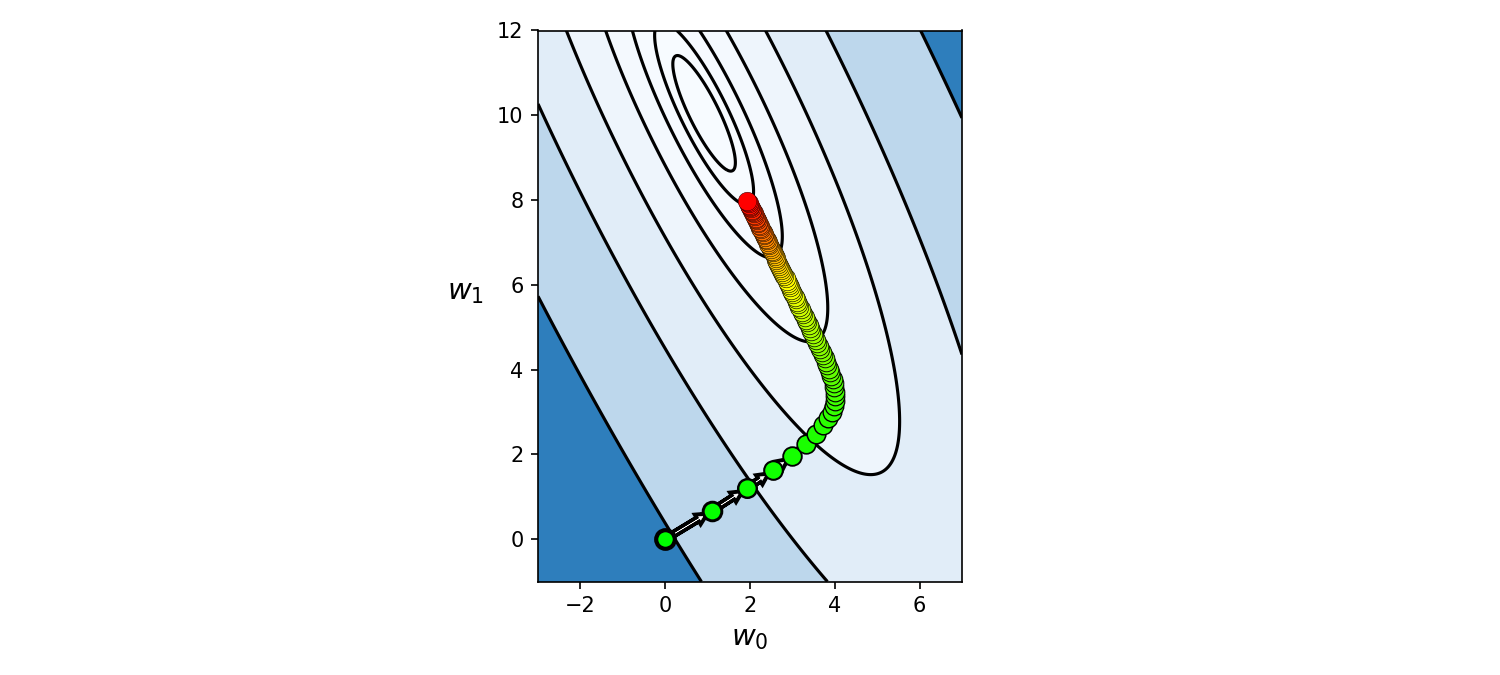

In [4]:
## This code cell will not be shown in the HTML version of this notebook
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 100; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -3,xmax = 7,ymin = -1,ymax = 12,num_contours = 7,show_original = False)

Here as usual the steps are colored from green to red as gradient descent begins (green) to when it ends (red).  From this perspective we can see that we still have a way to travel to reach the minimum of the cost function.  Moreover, gradient descent is naturally slowing down as we approach the global minimum here - so we will need quite a few additional steps to reach an appropriate solution.

Plotting the line given by the final set of weights learned in this run of standard gradient descent - those associated with the final red point plotted on the contour plot above - we can see that the fact that these weights lie so far from the true minimum of the cost function truly affect the line's quality - we get poor fit considering how simple the dataset is.

<IPython.core.display.Javascript object>


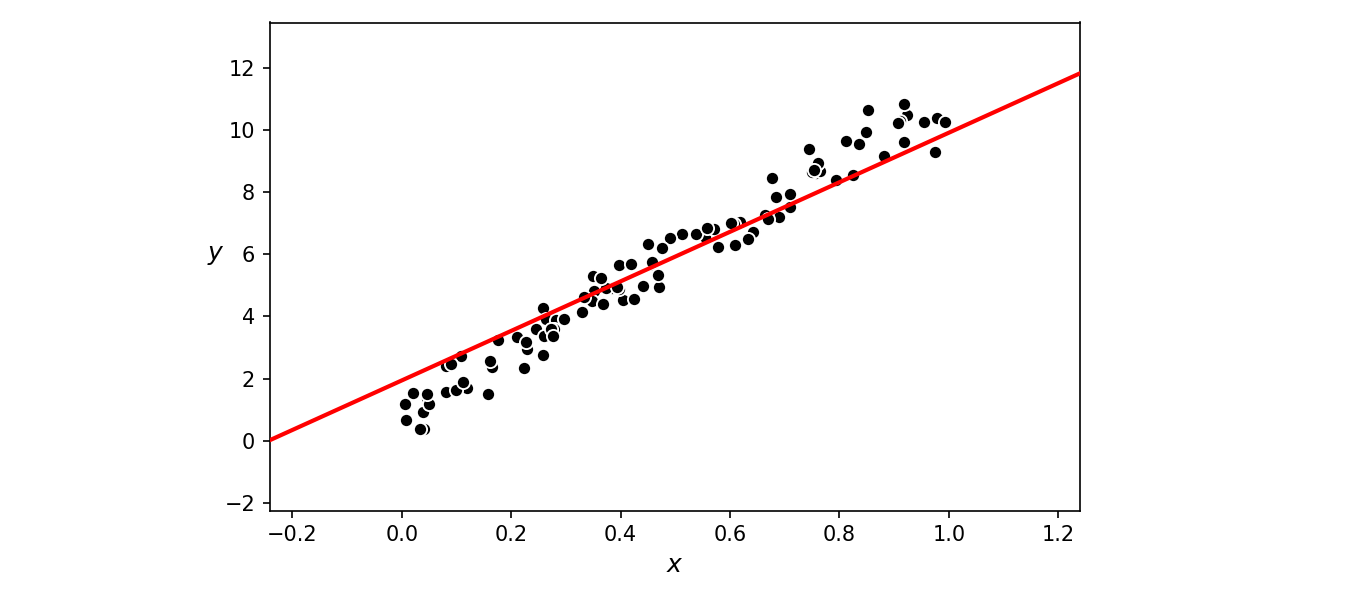

In [5]:
## This code cell will not be shown in the HTML version of this notebook
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights_1 = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights_1],colors = ['r'])

We can actually make an extremely simple adjustment of the data ameliorates this issue significantly, altering the shape of our Least Squares cost function so that its contours are much more *circular* (thus making it considerably easier for gradient descent to find global minima).  This simple adjustment is called *standard normalization*.  In particular, we normalize our inputs to have *zero mean and unit standard deviation*. 

 What does this look like?  Well we just replace each input $x_p$ point with its mean centered unit deviation analog as 

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu}{\sigma}
\end{equation}

where the sample mean of the inputs $\mu$ is defined as 

\begin{equation}
\mu = \frac{1}{P}\sum_{p=1}^{P}x_p \\
\end{equation}

and the sample standard deviation of the inputs $\sigma$ is defined as 

\begin{array}
\
\sigma = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_p - \mu \right)^2}.
\end{array}

This simple normalization scheme is often called *standard normalization*.

As we will see below for the particular dataset we are currently studying, this simple normalization 'trick' has a profound impact on the shape of our cost function.  Also note: this normalization scheme is *invertible*, meaning that after performing it we can always return to our original data by simple re-multiplying a normalized input by the original standard deviation and adding the original mean.  

In [6]:
# standard normalization function - returns functions for standard normalizing and reverse standard
# normalizing an input dataset x
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [7]:
## This code cell will not be shown in the HTML version of this notebook
# return normalization functions based on input x
normalizer,inverse_normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x_normalized = normalizer(x)

Now we form a Least Squares cost function with our normalized input, with the output un-changed.

With our cost function formed we now plot its contours, just as done previously.  As you can see - amazingly - the contours of this Least Squares cost (with normalized input) are perfectly circular.  No long narrow valleys can ever exist in such a function, and so gradient descent can much more rapidly minimize this cost.

<IPython.core.display.Javascript object>


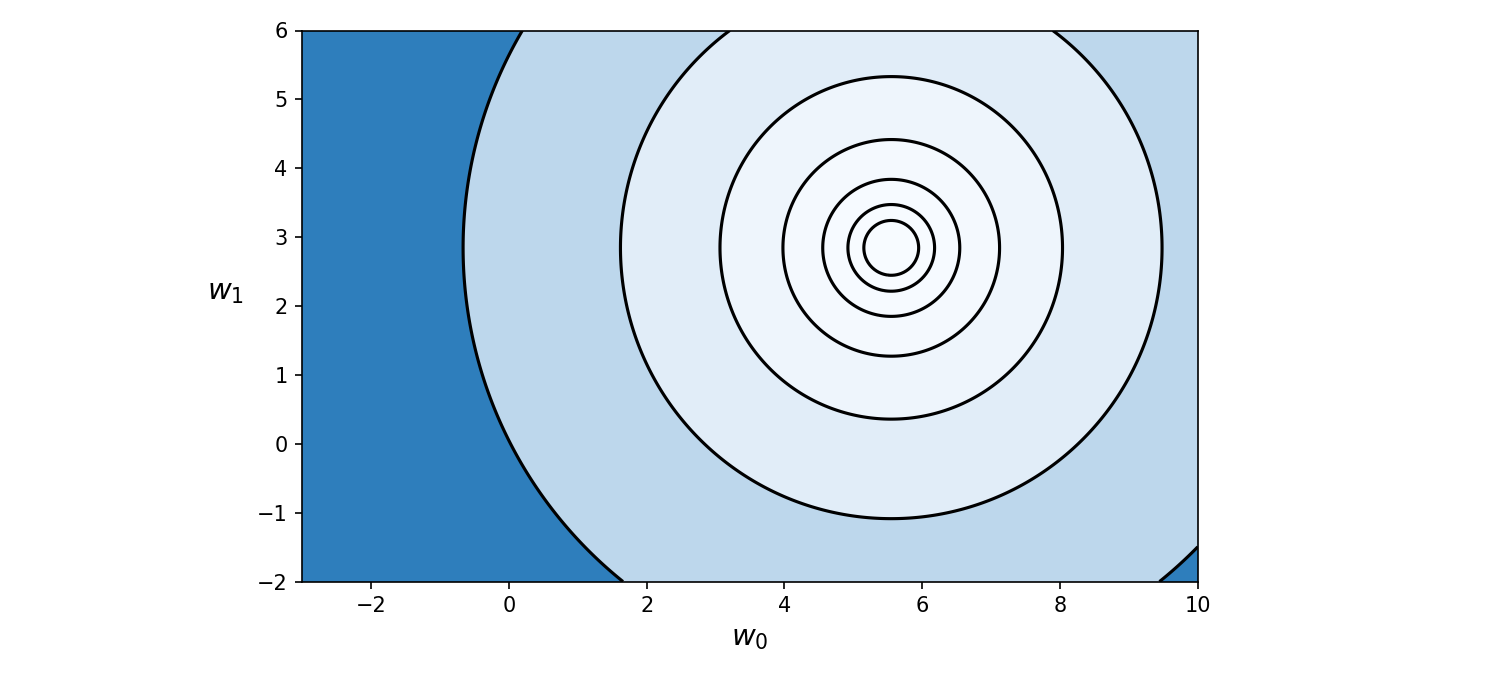

In [8]:
## This code cell will not be shown in the HTML version of this notebook
# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares_2 = cost_lib.choose_cost(x_normalized,y,'least_squares')

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(least_squares_2,[],xmin = -3,xmax = 10,ymin = -2,ymax = 6,num_contours = 7,show_original = False)

Below we show an animation where we form a sequence of Least Squares cost functions using a convex combination of the original and normalized data 

\begin{equation}
\left(1 - \lambda\right)x_p + \lambda \left( \frac{x_p - \mu}{\sigma} \right)
\end{equation}

where $\lambda$ ranges from $0$ (i.e., we use the original input) to $\lambda = 1$ (where we use the normalized versions).  Plotting the contour of each Least Squares cost for a $50$ evenly spaced values of $\lambda$ between $0$ and $1$ shows how the original Least Squares cost function is transformed by normalizing the input.  You can use the slider below to transition between the contours of the original cost function (when the slider is all the way to the left) and cost function taking in normalized input (when the slider is all the way to the right).  

In [9]:
## This code cell will not be shown in the HTML version of this notebook
# animation showing cost function transformation from standard to normalized input
scaling_tool = feature_scaling_tools.Visualizer(x,x_normalized,y,'least_squares')
savepath = 'videos/animation_1.mp4'
scaling_tool.animate_transition(savepath,num_frames=50,xmin = -12,xmax = 15,ymin = -10,ymax = 30,num_contours = 7,fps=10)

In [10]:
## This code cell will not be shown in the HTML version of this notebook
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_1.mp4" type="video/mp4">
  </video>
""")

In the next ``Python`` cell we repeat our previous run of unnormalized gradient descent - beginning at the same initial point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$, using a steplength parameter $\alpha = 10^{-1}$ (the largest steplength value of the form $10^{-\gamma}$ we could find that caused the algorithm to converge).   However here we will only take $20$ steps instead of $100$ as we did before, since we basically reach the minimum after just a few steps now (no more long narrow valleys to struggle through!).

In [50]:
## This code cell will not be shown in the HTML version of this notebook
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares_2; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 20; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -3,xmax = 10,ymin = -2,ymax = 6,num_contours = 7,show_original = False)

<IPython.core.display.Javascript object>

Using only a quarter of the number of descent steps - with precisely the same setup as previously - we get *much closer* to the cost function minimum!  

Let us plot the fit associated with the final set of weights (the final red point above) on our original dataset below.   Notice that in order to make this plot we must treat each new *input test point* on the linear predictor precisely as we treated our original input: i.e., we must subtract off the same mean and divide off the same standard deviation.  Thus with our fully tuned parameters $w_0^{\star}$ and $w_1^{\star}$ our linear predictor for any input point $x$ is, instead of $ w_0^{\star} + w_1^{\star}x^{\,}$, now

\begin{equation}
\text{normalized_predictor}\left(x\right) = w_0^{\star} + w_1^{\star}\left(\frac{x - \mu}{\sigma}\right).
\end{equation}

Again - since we normalized the input data we trained on, we must normalize any new input point we shove through our trained linear model.

The final predictor - plotted below in red - is far superior to the one we found previously, where we took $5$ times as many gradient descent steps, prior to normalizing the input data.  

<IPython.core.display.Javascript object>


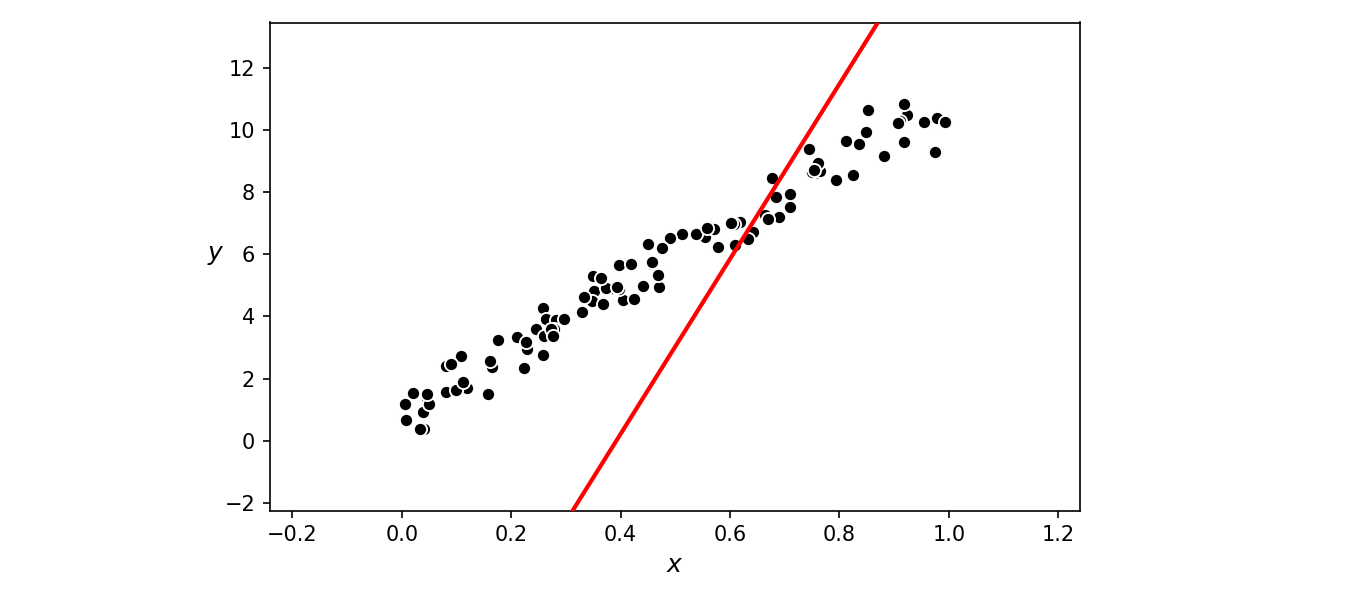

In [12]:
## This code cell will not be shown in the HTML version of this notebook
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights_2 = weight_history[ind]
transformers = [normalizer]
demo.plot_fit(plotting_weights = [least_weights_2],colors = ['r'],transformers = transformers)

---

Now that we have seen empirical evidence that the standard normalization scheme significantly aids with parameter tuning with single-input linear regression, we explore (by example) how the same normalization scheme likewise helps significantly with the  multi-input datasets as well.  In the subsections that follow this one we summarize our findings, and provide more rigorous (mathematical) evidence to backup these experimental findings.  In particular we will use the $N = 5$ input dimension regression dataset loaded in the below.  This dataset consists of a selection of random points taken from a random hyperplane in six dimensions (five inputs, one output), with absolutely no noise whatsoever added to the output. 

Lets examine the numerical range of each input dimension / feature.  In the next cell we plot a discrete histogram of each input feature.  

<IPython.core.display.Javascript object>


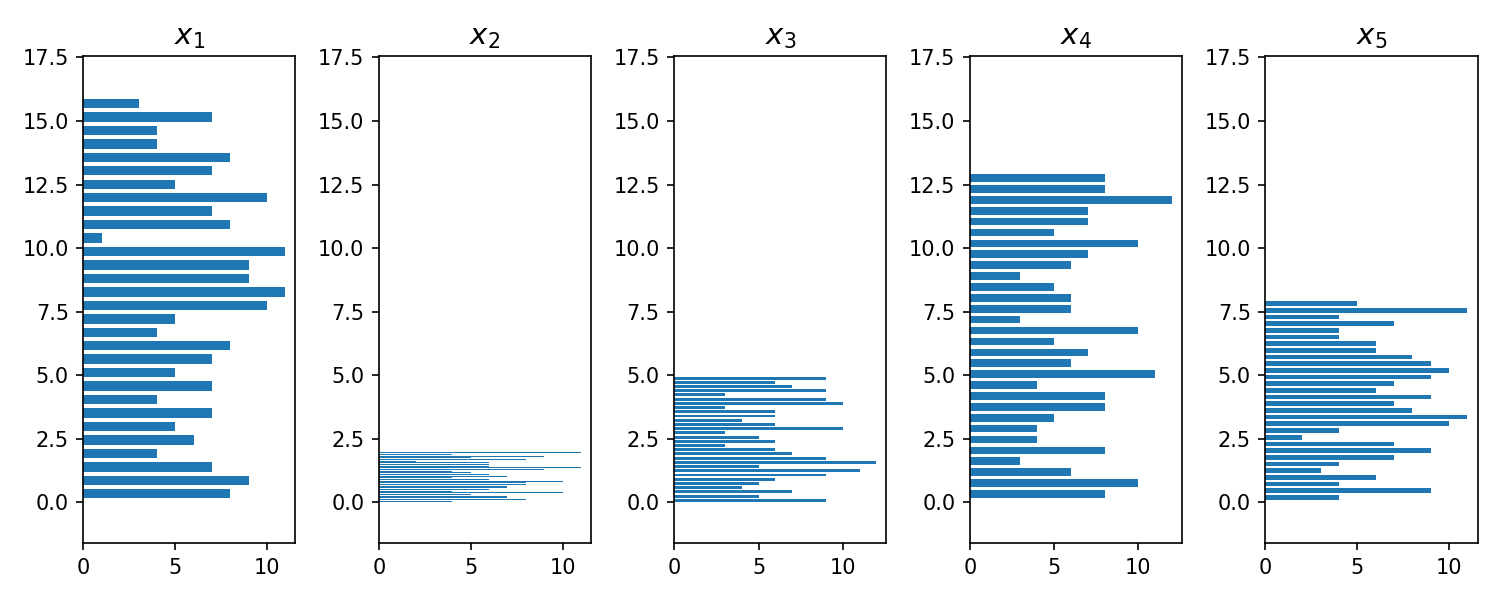

In [13]:
## This code cell will not be shown in the HTML version of this notebook
# load data
data = np.loadtxt(datapath + 'highdim_multirange_linregress.csv',delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# plot the distribution of each input feature
scaling_tool = feature_scaling_tools.Visualizer([],[],[],[])
scaling_tool.feature_distributions(x)

As we can see in the plot above, the distributions of our input features here are way out of scale with each other, so we can expect gradient descent to converge quite slowly here - unless we normalize each input feature to have a similar distribution.

In analogy to the single-input case, here we should normalize *each feature individually* - that is each coordinate direction $x_n$.  What are we trying to avoid by doing this?  The (common) scenario where the distribution of input along each individual input dimensions widely varies, since this leads to a cost function with long narrow valley(s) that substantially slows down gradient descent.

Thus with the aim of standardizing each input direction - also referred to as a *feature* - we should normalize the $n^{th}$ input dimension of an $N$-input dimensional dataset $\left\{\mathbf{x}_p,y_p\right\}_{p=1}^P$ as 

\begin{equation}
x_{p,n} \longleftarrow \frac{x_{p,n} - \mu_n}{\sigma_n}
\end{equation}

where $x_{p,n}$ is the $n^{th}$ coordinate of point $\mathbf{x}_p$ and $\mu_n$ and $\sigma_n$ are the mean and standard deviation of the $n^{th}$ dimension of the data, respectively, and are defined as 

\begin{array}
\
\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n} \\
\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_{p,n} - \mu_n \right)^2}
\end{array}

Note that if $\sigma_n = 0$ for some $n$ the formula above makes little sense.  However in this case the corresponding input feature is *redundant* and should be *removed from the dataset* entirely, since this implies that each and every $x_{p,n}$ is *exactly the same constant value* and thus *absolutely nothing* can be learned from its presence in the model.  Indeed checking that the standard deviation of  an input feature is greater than zero is a principle way of removing redundant input features from a dataset.

Now lets look at the distribution of our normalized input features.  

<IPython.core.display.Javascript object>


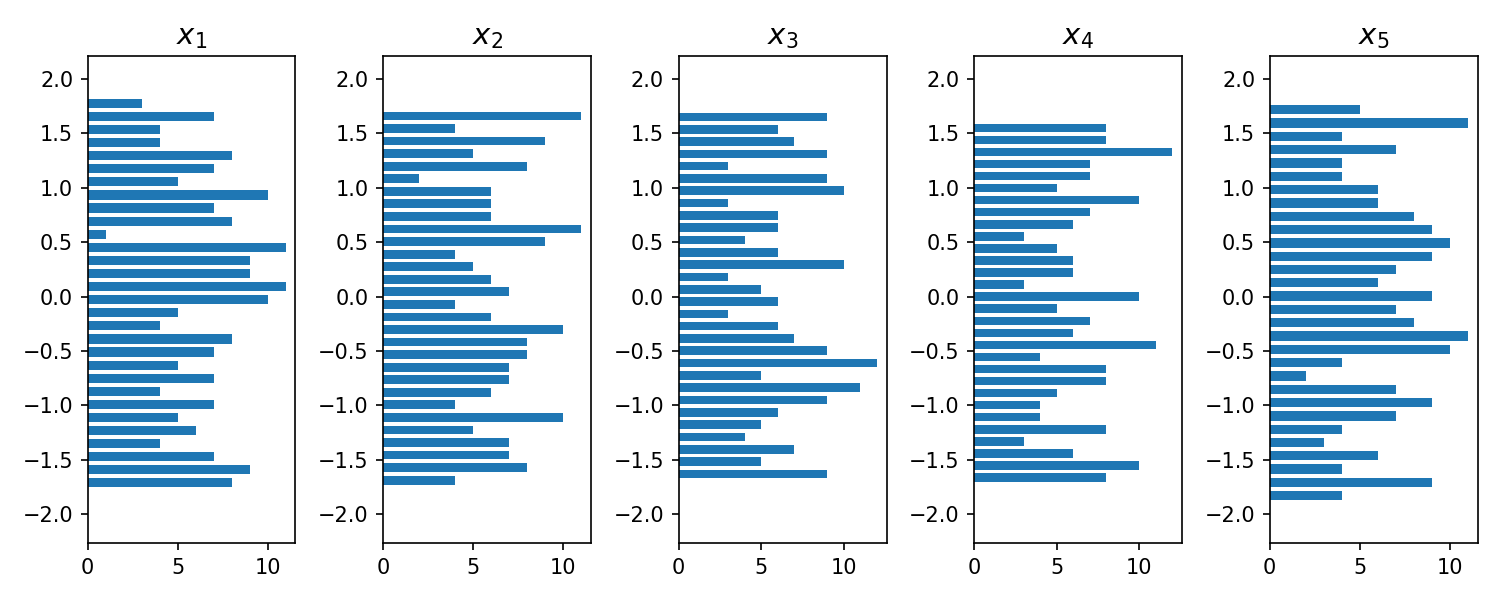

In [14]:
## This code cell will not be shown in the HTML version of this notebook
# create normalizer based on input
normalizer,inverse_normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x_normalized = normalizer(x)

# plot the distribution of each input feature
scaling_tool.feature_distributions(x_normalized)

Much better!  With each input distribution normalized and roughly looking the same we can intuit, no individual weight $w_n$ will be significantly more sensitive (to proper tuning) than the others, and we can expect gradient descent to have a much easier time here.

Lets make a similar run of gradient descent using both the original and normalized data, comparing the results in terms of the cost function history plots.  Here we use the same initial point, and the smallest fixed steplength parameter in each instance of the form $10^{-\gamma}$ for nonnegative $\gamma$ that produced convergence.

<IPython.core.display.Javascript object>


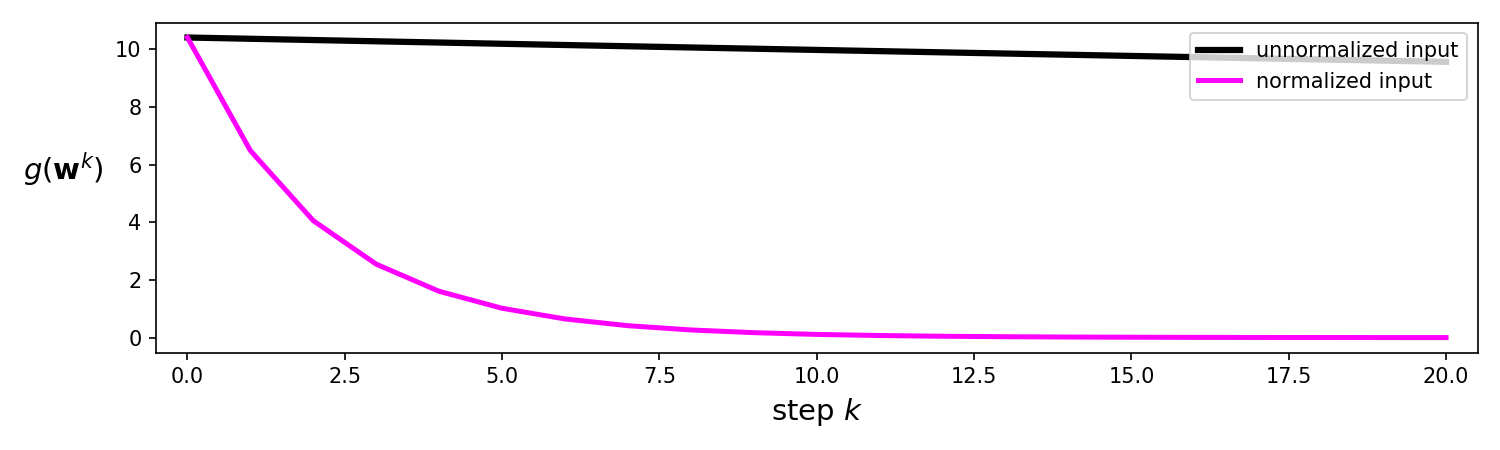

In [15]:
## This code cell will not be shown in the HTML version of this notebook
### least squares functions for both our original and normalized data
least_squares = cost_lib.choose_cost(x,y,'least_squares')
least_squares_2 = cost_lib.choose_cost(x_normalized,y,'least_squares')

### run gradient descent for each input
g = least_squares; w = np.zeros((6,1)); max_its = 20; alpha_choice = 10**(-3);
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

g = least_squares_2; w = np.zeros((6,1)); max_its = 20; alpha_choice = 10**(-1);
weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['unnormalized input','normalized input'])

As we can see, by normalizing each of the input features gradient descent converges much more quickly.

Note to evaluate any new test point $\mathbf{x}$ - using our fully tuned parameters $w_0^{\star},w_1^{\star},...,w_N^{\star}$,we have to treat it as we did our training data - by normalizing each input feature using the same statistics we computed on the training data above.

\begin{equation}
\text{normalized_model}\left(\mathbf{x}\right) = w_0^{\star} + w_1^{\star}\left(\frac{x_1 - \mu_1}{\sigma_1}\right) + w_2^{\star}\left(\frac{x_2 - \mu_2}{\sigma_2}\right) + \cdots + w_N^{\star}\left(\frac{x_N - \mu_N}{\sigma_N}\right).
\end{equation}

##  Standard normalization of classification data

Below we load in a simple two class dataset with $N=1$ input feature.  A quick glance at the data and we can intuit that - if tuned properly - a two class linear classifier will perform very well on this dataset, as the data appears to be largely separable by a zero-dimensional line (i.e., a point).

<IPython.core.display.Javascript object>


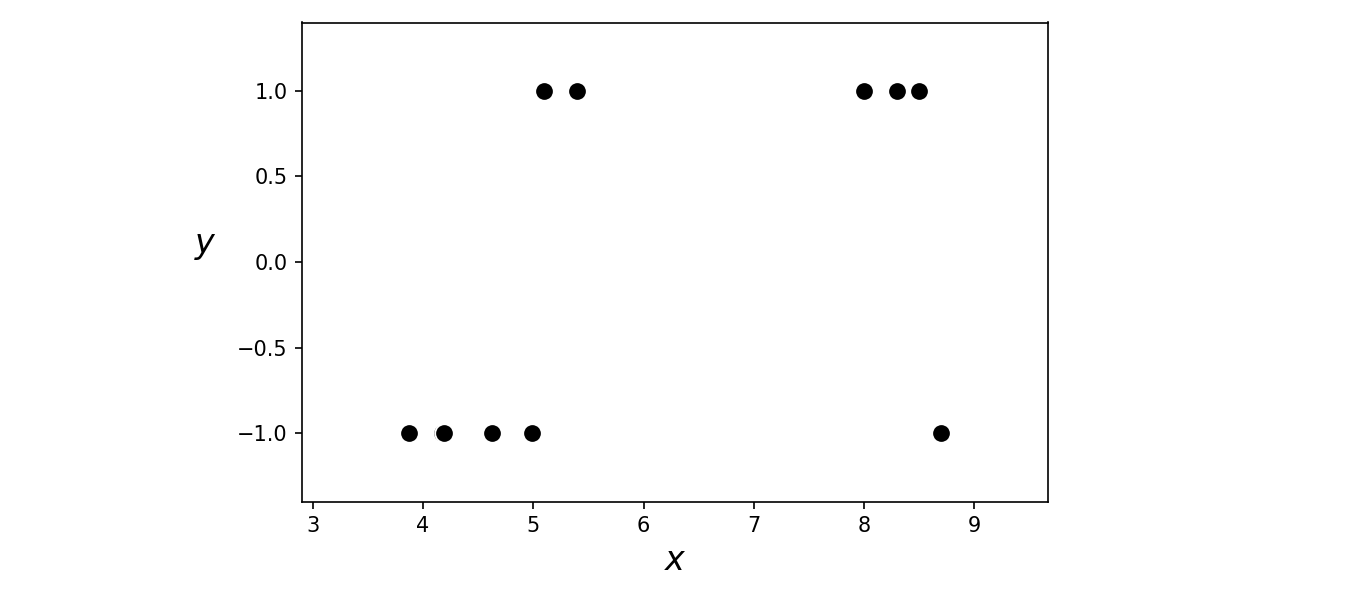

In [16]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '2d_classification_data_v1.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:] + 4
y = data[-1:,:] 
y[0,-1] = -1

# reform data with adjustments
data = np.vstack((x,y))

# plot dataset
demo = classif_plotter.Visualizer(data)
demo.plot_data()

Since we only need properly tune two parameters in learning a linear classifier for this dataset, we can visualize any classification cost function over it.  Here we will use the softmax cost.  Below we load in this cost function from a backend file - containing precisely the softmax cost implemented in [Section 6.3](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_3_Softmax.html) - and then show its contour plot over the above dataset.

The contours of this function are extremely long and narrow - and so we can predict that gradient descent will struggle immensely (zig-zagging very slowly - as we first described in [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html)) in determining the global minimum (located inside the smallest contour shown below). 

<IPython.core.display.Javascript object>


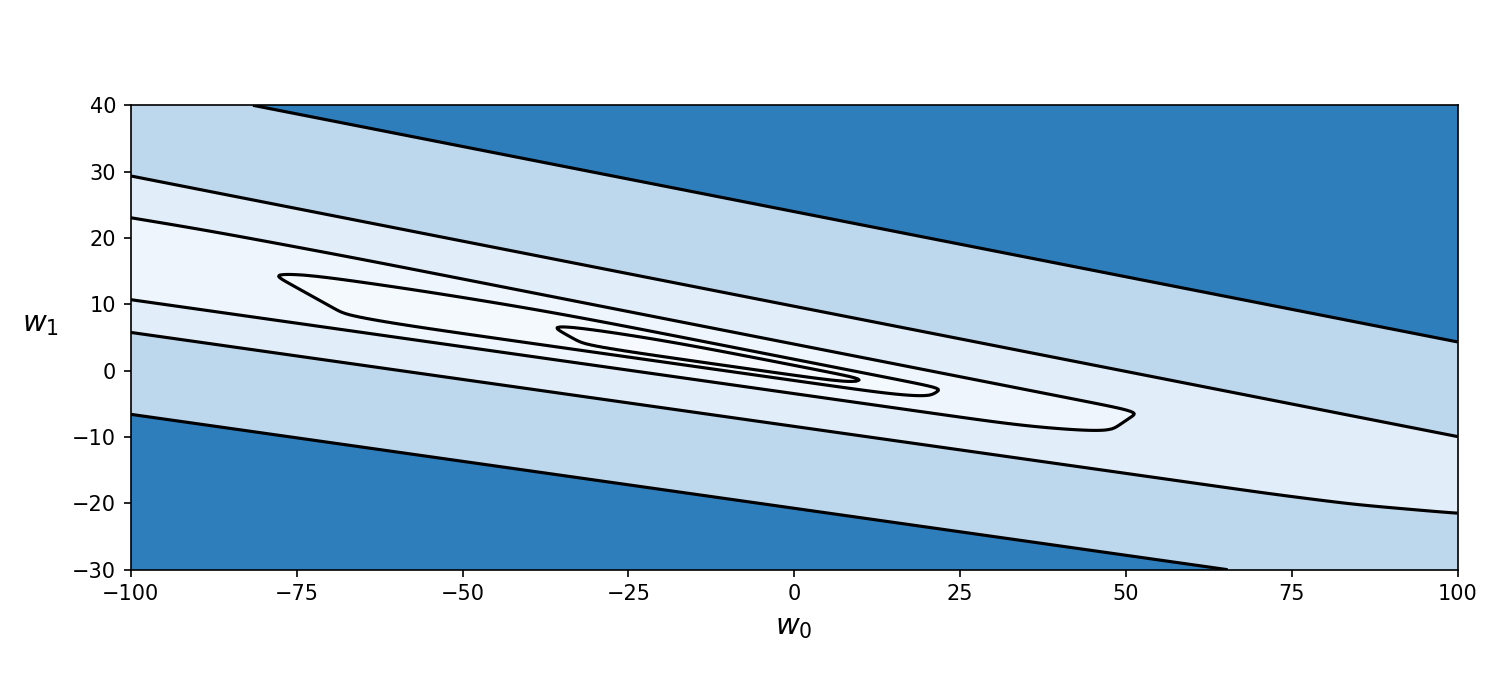

In [17]:
# This code cell will not be shown in the HTML version of this notebook
# load in cost function
softmax = cost_lib.choose_cost(x,y,'softmax')
counting_cost = cost_lib.choose_cost(x,y,'counter')

# show the contours of an input function over a desired viewing range
static_plotter.two_input_contour_plot(softmax,[],xmin = -100,xmax = 100,ymin = -30,ymax = 40,num_contours = 5,show_original = False)

We can confirm this intuition regarding gradient descent by making a run - which we do below.  Beginning at the point $\mathbf{w} = \begin{bmatrix} 20 \\ 30 \end{bmatrix}$ we visualize $100$ steps of gradient descent with a fixed steplength $\alpha = 1$.  This was the largest steplength size of the form $10^{-\gamma}$ with $\gamma$ an integer that we found that did not cause gradient descent to diverge here.mm

<IPython.core.display.Javascript object>


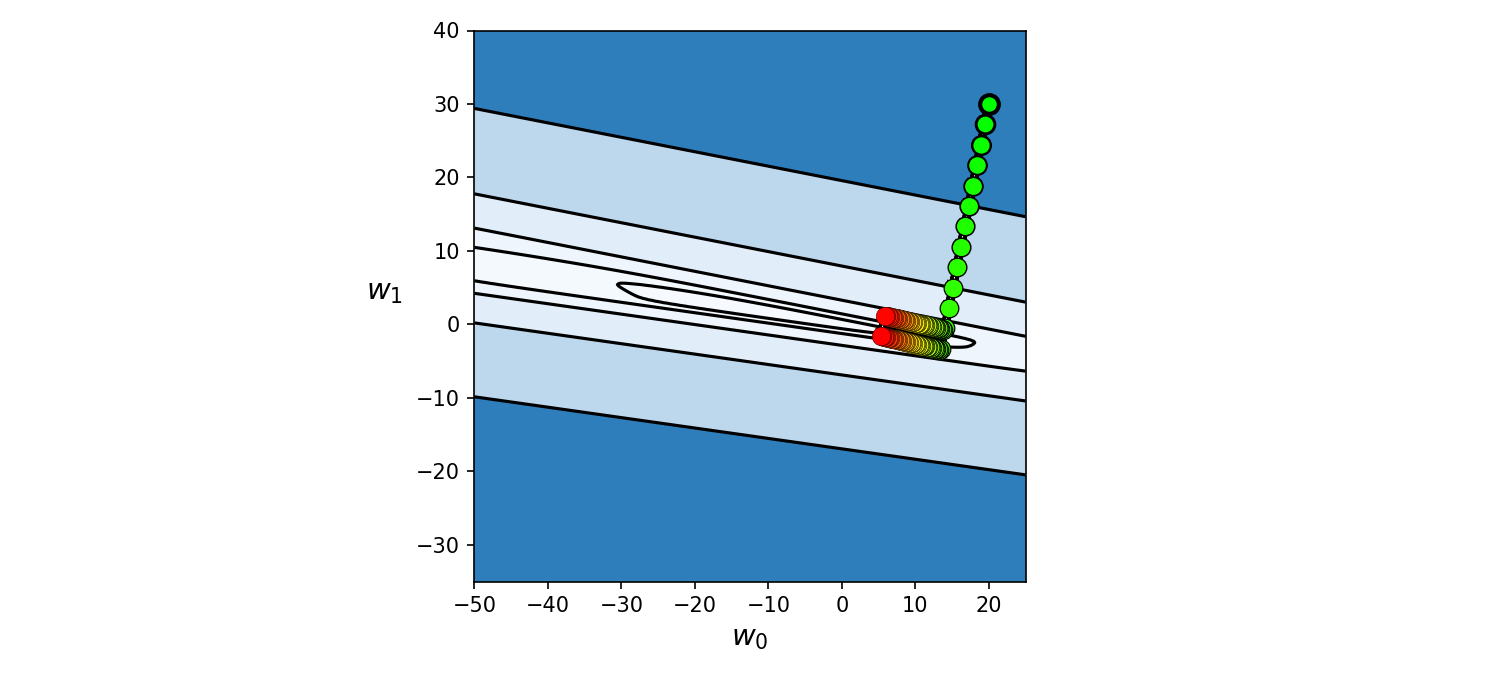

In [18]:
# This code cell will not be shown in the HTML version of this notebook
# load in an optimizer
g = softmax; w = np.array([20.0,30.0])[:,np.newaxis]; max_its = 100; alpha_choice = 1;
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_1 = [counting_cost(v) for v in weight_history_1]  # compute misclassification history

# show run on contour plot
static_plotter.two_input_contour_plot(softmax,weight_history_1,xmin = -50,xmax = 25,ymin = -35,ymax = 40,num_contours = 5,show_original = False)

Here as usual the steps are colored from green to red as gradient descent begins (green) to when it ends (red).  From this perspective we can see that we still have a long way to travel to reach the minimum of the cost function, and that these steps will likely continue to zig-zag considerably. 

Plotting the logistic sigmoid (in red) given by the final set of weights learned in this run of gradient descent - those associated with the final red point plotted on the contour plot above - we can see that the fact that these weights lie so far from the true minimum of the cost function truly affect the classifier's quality immensely - we learn a poor classifier here. 

<IPython.core.display.Javascript object>


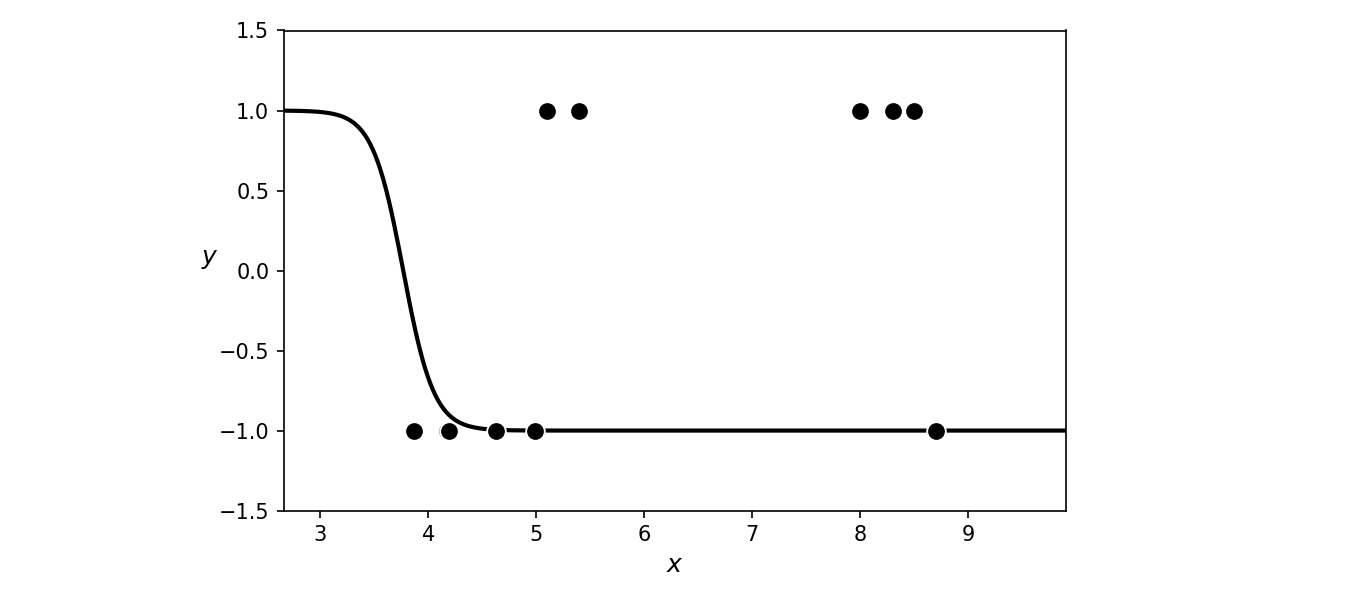

In [19]:
# This code cell will not be shown in the HTML version of this notebook
# the original data and the best learned logistic sigmoid and counting cost
# line learned from our gradient descent run above
ind = np.argmin(count_history_1)
best_weights_1 = weight_history_1[ind]
demo.plot_fit([best_weights_1])

Above we saw how normalizing input drastically improved the topology of linear regression cost functions, making it much easier for gradient descent (as well as other local optimization methods) to find global minima and hence learn a proper linear regressor.  Here we will see how *standard normalization* provides precisely the same benefit in the context of two class linear classification.

Thus we will normalize our our input by subtracting off its mean and dividing by its standard deviation - precisely as we did with linear regression.  This means we will replace each input $x_p$ point with its mean centered unit deviation analog as 

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu}{\sigma}
\end{equation}

where the sample mean of the inputs $\mu$ is defined as 

\begin{equation}
\mu = \frac{1}{P}\sum_{p=1}^{P}x_p \\
\end{equation}

and the sample standard deviation of the inputs $\sigma$ is defined as 

\begin{array}
\
\sigma = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_p - \mu \right)^2}.
\end{array}

As we will see below for the particular dataset we are currently studying, this simple normalization 'trick' has a profound impact on the shape of our cost function.  Also note: this normalization scheme is *invertible*, meaning that after performing it we can always return to our original data by simple re-multiplying a normalized input by the original standard deviation and adding the original mean. 

Lets now examine the contours of the softmax cost function using the normalized input.  As we can see below, the contours of this cost function are drastically improved.

<IPython.core.display.Javascript object>


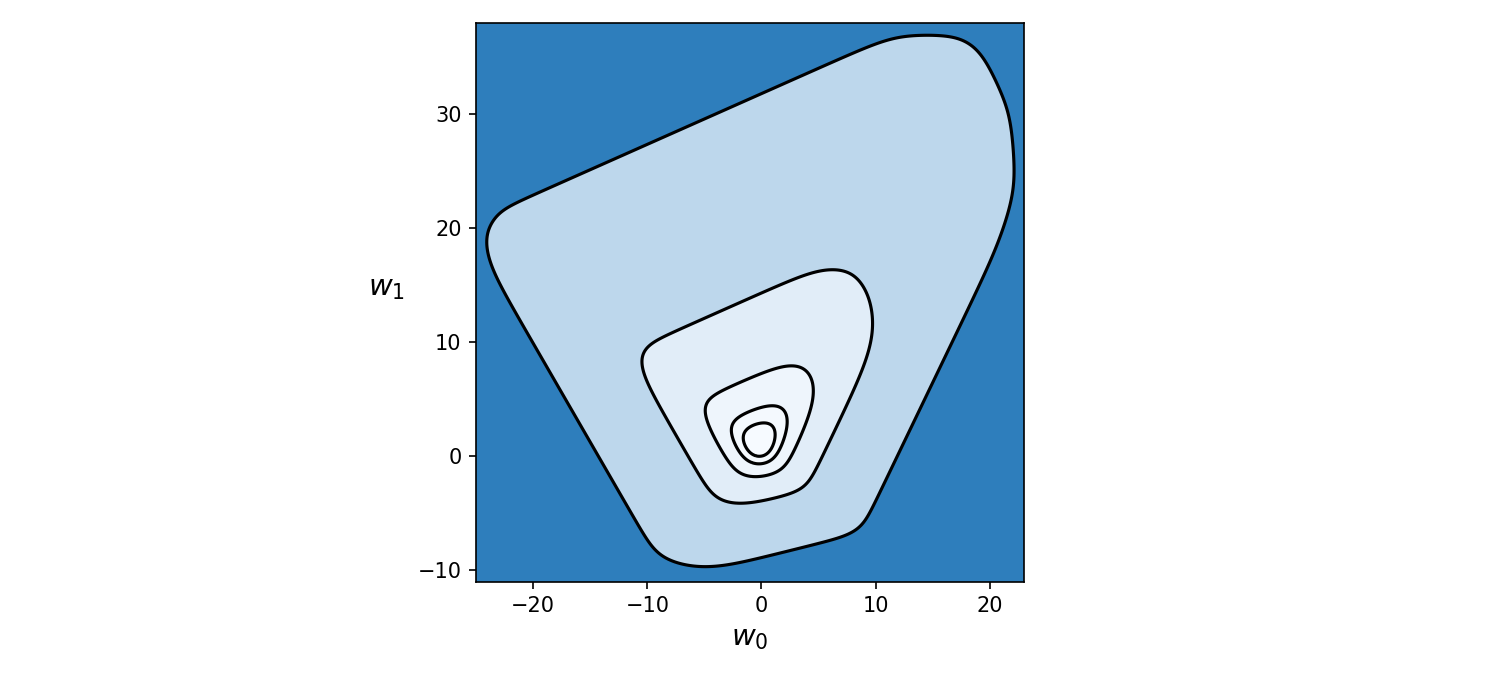

In [20]:
# This code cell will not be shown in the HTML version of this notebook
# create normalizer
normalizer,inverse_normalizer = standard_normalizer(x)

# normalize input
x_normalized = normalizer(x)

# define new cost with normalized data
softmax_2 = cost_lib.choose_cost(x_normalized,y,'softmax')

# show the contours of an input function over a desired viewing range
static_plotter.two_input_contour_plot(softmax_2,[],xmin = -25,xmax = 23,ymin = -11,ymax = 38,num_contours = 5,show_original = False)

Below we show an animation where we form a sequence of softmax cost functions using a convex combination of the original and normalized data 

\begin{equation}
\left(1 - \lambda\right)x_p + \lambda \left( \frac{x_p - \mu}{\sigma} \right)
\end{equation}

where $\lambda$ ranges from $0$ (i.e., we use the original input) to $\lambda = 1$ (where we use the normalized versions).  Plotting the contour of each softmax cost for a $50$ evenly spaced values of $\lambda$ between $0$ and $1$ shows how the original softmax cost function is transformed by normalizing the input.  You can use the slider below to transition between the contours of the original cost function (when the slider is all the way to the left) and cost function taking in normalized input (when the slider is all the way to the right).  

In [21]:
# This code cell will not be shown in the HTML version of this notebook
# animation showing cost function transformation from standard to normalized input
scaling_tool = feature_scaling_tools.Visualizer(x,x_normalized,y,'softmax')
savepath = 'videos/animation_2.mp4'
scaling_tool.animate_transition(savepath,num_frames=50,xmin = -25,xmax = 23,ymin = -11,ymax = 38,num_contours = 5,fps=10)

In [22]:
## This code cell will not be shown in the HTML version of this notebook
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_2.mp4" type="video/mp4">
  </video>
""")

Now we make a run of gradient descent to find an approximate global minimum of this softmax cost.  We will initialize at precisely the same point as was done previously, and use the largest steplength of the form $10^{-\gamma}$ possible, which in this instance is $\alpha = 10$.  Whenever we normalize input like this we can always use a larger fixed steplength value.  Here - however - we will only use $25$ steps (one-fourth as many as we ran above in minimizing the softmax with un-normalized data).  Nonetheless even with so few steps - as can be seen below - we easily minimize the softmax cost and find an approximate global global minimum.

<IPython.core.display.Javascript object>


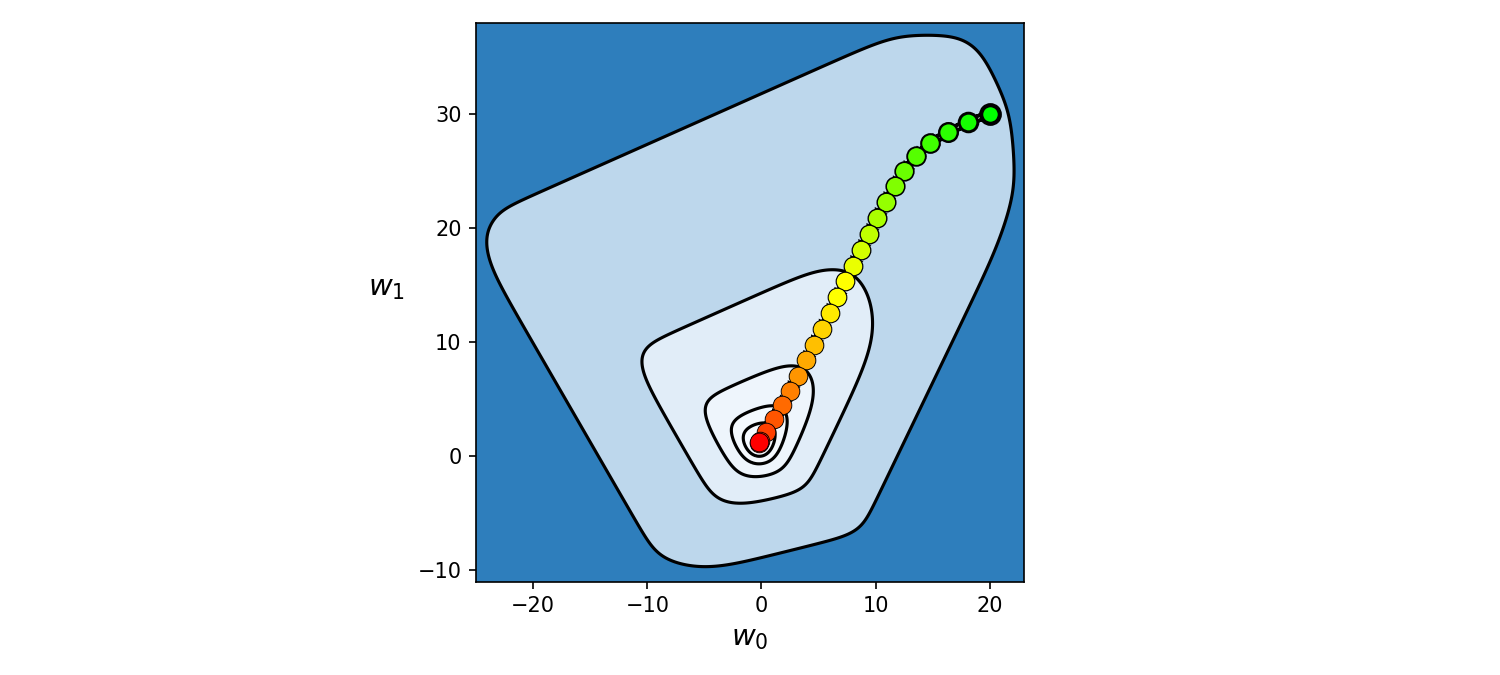

In [23]:
# This code cell will not be shown in the HTML version of this notebook
# load in an optimizer
g = softmax_2; w = np.array([20.0,30.0])[:,np.newaxis]; max_its = 25; alpha_choice = 10;
weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_2 = [counting_cost(v) for v in weight_history_2]  # compute misclassification history

# s of an input function over a desired viewing range
static_plotter.two_input_contour_plot(softmax_2,weight_history_2,xmin = -25,xmax = 23,ymin = -11,ymax = 38,num_contours = 5,show_original = False)

Using only a quarter of the number of descent steps - with precisely the same setup as previously - we get *much closer* to the cost function minimum!  

Let us plot the logistic cost associated with the final set of weights (the final red point above) on our original dataset below.   Notice - just as with linear regression - that in order to make this plot we must treat each new *input test point* on the predictor precisely as we treated our original input: i.e., we must subtract off the same mean and divide off the same standard deviation.  Thus with our fully tuned parameters $w_0^{\star}$ and $w_1^{\star}$ our linear predictor for any input point $x$ is, instead of $ w_0^{\star} + w_1^{\star}x^{\,}$, now

\begin{equation}
\text{normalized_model}\left(x\right) = \text{tanh}\left(w_0^{\star} + w_1^{\star}\left(\frac{x - \mu}{\sigma}\right)\right).
\end{equation}

Again - since we normalized the input data we trained on, we must normalize any new input point we shove through our trained logistic model.

The final logistic predictor - plotted below in red below respectively - is far superior to the one we found previously, where we took $4$ times as many gradient descent steps, prior to normalizing the input data.  

<IPython.core.display.Javascript object>


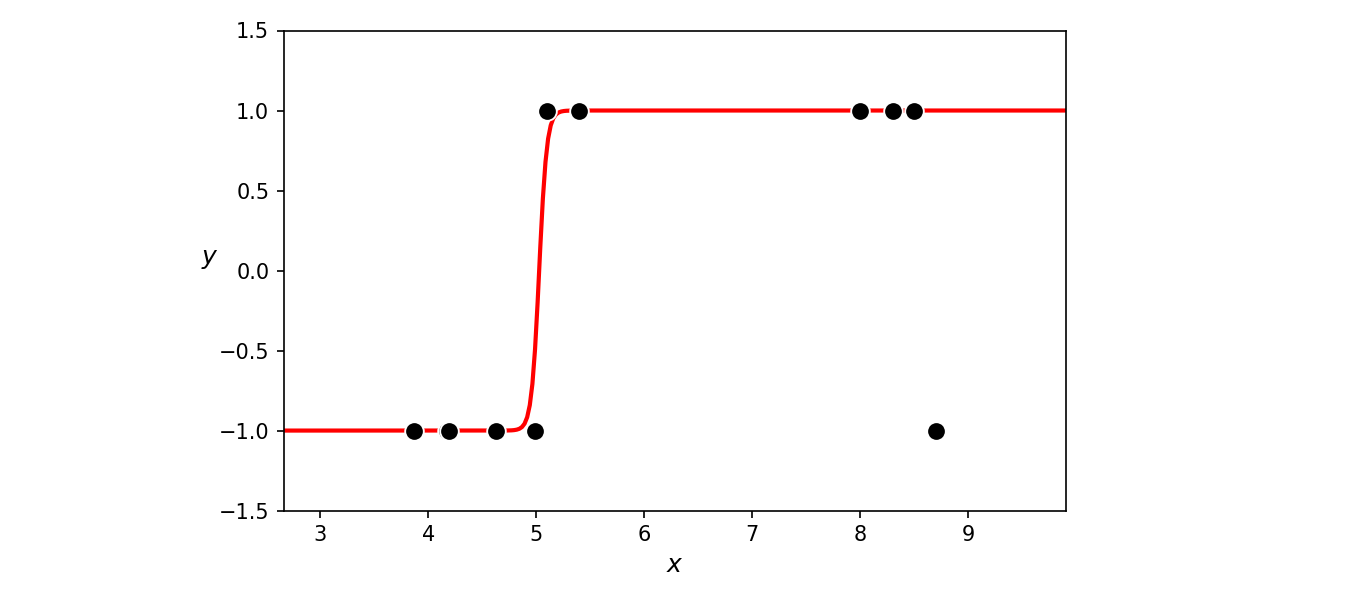

In [24]:
# This code cell will not be shown in the HTML version of this notebook
# the original data and the best learned logistic sigmoid and counting cost
# line learned from our gradient descent run above
ind = np.argmin(count_history_2)
best_weights_2 = weight_history_2[ind]
transformers = [normalizer]
demo.plot_fit([best_weights_2],colors = ['r'],transformers = transformers)

---

As with linear regression, with two class classification when dealing with $N$ dimensional input datasets we can normalize each input feature precisely as we did above, and gain the same sort of benefit in terms of speeding up gradient descent.  This means we mean normalize and divide off the standard deviation a long each input axis, replacing each coordinate of our input data as

\begin{equation}
x_{p,n} \longleftarrow \frac{x_{p,n} - \mu_n}{\sigma_n}
\end{equation}

where $x_{p,n}$ is the $n^{th}$ coordinate of the $p^{th}$ input point and $\mu_n$ and $\sigma_n$ are the mean and standard deviation of the $n^{th}$ dimension of the data, respectively, and are defined as 

\begin{array}
\
\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n} \\
\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_{p,n} - \mu_n \right)^2}.
\end{array}

Generally speaking the only time when this kind of standard normalization will not be helpful is when the input along a certain dimension of a dataset is *constant* and has *zero* standard deviation i.e., $\sigma_n = 0$.  In scaling off this value we will then be dividing by $0$, which should always be avoided.  As discussed above such features are redundant and add nothing to a machine learnimg model, and thus should be removed.

Note to evaluate any new test point $\mathbf{x}$ - using our fully tuned parameters $w_0^{\star},w_1^{\star},...,w_N^{\star}$,we have to treat it as we did our training data - by normalizing each input feature using the same statistics we computed on the training data above.

\begin{equation}
\text{normalized_model}\left(\mathbf{x}\right) = \text{tanh}\left(w_0^{\star} + w_1^{\star}\left(\frac{x_1 - \mu_1}{\sigma_1}\right) + w_2^{\star}\left(\frac{x_2 - \mu_2}{\sigma_2}\right) + \cdots + w_N^{\star}\left(\frac{x_N - \mu_N}{\sigma_N}\right)\right).
\end{equation}

##  Summary and discussion

The empirical findings described in this Section are indicative of the more general utility of standard normalization in general.  First and foremost, they is indicative of a more general truth regarding machine learning cost functions: *normalizing the input features of a dataset by mean centering and scaling by the standard deviation of each input will results in a cost function with less elliptical and more 'circular' contours*.  This includes regression, (two-class / multi-class) classification, as well as unsupervised learning cost functions.  Below we illustrate this statement graphically.  In the top row we show the input (only) of a prototypical $N = 2$ dimensional input dataset (top left panel), as well as its mean-centered (top middle panel), and scaled version (top right panel).  Once complete, this invertible transformation results in a centered and more compactly confined version of the data.  Simultaneously - as shown in the bottom row where a prototypical cost function corresponding to this data is shown - standard normalization results in a cost function with much 'nicer' and less elliptical contours. 

<figure>
  <img src= '../../mlrefined_images/superlearn_images/standard_normalization_data_and_contours.png' width="100%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> 

The result of applying standard normalization to the input of a prototypical dataset.  In the top row we show the two-dimensional input (top left panel), as well as its mean-centered (top middle panel), and scaled version (top right panel).  Once complete this invertible transformation results in a centered and more compactly confined version of the data.  Simultaneously - as shown in the bottom row where a prototypical cost function corresponding to this data is shown - standard normalization results in a cost function with much 'nicer' and less elliptical contours.  The original cost function - shown on the left - is tempered and has more 'circular' contours once the data is normalized.  


</em>  </figcaption> 
</figure>

Why is it the case that making the contours of a cost function less 'elliptical' and more 'circular' helps make optimization easier when using a first order optimization method like gradient descent?  Because - as discussed in [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html) - that the gradient descent direction *always* points perpendicular to the contours of a cost function.  This means that - when applied to minimize a cost function with elliptical contours like the example shown in the left panel below - that the gradient descent direction (while still a descent direction) points *away* from the global minimum of the function.  This characteristic naturally leads the gradient descent algorithm to take 'zig-zag' steps back and forth particularly when in 'long narrow valleys' like those present in the long axes of a cost function with elliptical contours.  

In normalizing the data we temper such elliptical contours, transforming them into more circular contours as shown in the middle and (ideally) the right panels below.  With more circular contours the gradient descent direction starts pointing more in the direction of the cost function minima, making each gradient descent step much more effective.  This also helps explain why we can typically use a much larger steplength parameter $\alpha$ when minimizing a cost function of standard normalized data - since the gradient descent direction points in a better direction we can freely travel in it much further at each step.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/better_contours.png' width="100%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> 
In normalizing input data we temper its associated cost function's often elliptical contours - like those shown in the left panel above - into more circular ones as shown in the middle and (ideally) the right panels.  This means that the gradient descent direction - which points away from the minima of a cost function when its contours are elliptical (leading to the common zig-zagging problem with gradient descent) - points more towards the function's minima as its contours become more circular.  This makes each gradient descent step much more effective, typically allowing the use of much larger steplength parameter values $\alpha$ meaning that measurably fewer steps are required to adequately minimize the cost function.
</em>  </figcaption> 
</figure>